# HEOM 1b: Spin-Bath model (very strong coupling)

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian, the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do this using the Matsubara, Pade and fitting decompositions, and compare their convergence.

This notebook shows a similar example to notebook 1a, but with much stronger coupling as discussed in [Shi *et al.*, J. Chem. Phys **130**, 084105 (2009)](https://doi.org/10.1063/1.3077918). Please refer to notebook HEOM 1a for a more detailed explanation.

As in notebook 1a, we present a variety of simulations using different techniques to showcase the effect of different approximations of the correlation function on the results:

- Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator
- Simulation 2: Matsubara decomposition (including terminator)
- Simulation 3: Pade decomposition
- Simulation 4: Fitting approach

Lastly we compare the results to using the Bloch-Redfield approach:

- Simulation 5: Bloch-Redfield

which does not give the correct evolution in this case.


### Drude-Lorentz (overdamped) spectral density

The Drude-Lorentz spectral density is:

$$J_D(\omega)= \frac{2\omega\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.  We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

As an example, the Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i)             & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \}    & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

## Setup

In [1]:
import contextlib
import time

import numpy as np
import matplotlib.pyplot as plt

from qutip import about, basis, brmesolve, expect, liouvillian, sigmax, sigmaz
from qutip.core.environment import DrudeLorentzEnvironment, system_terminator
from qutip.solver.heom import HEOMSolver

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating correlation function expansions, plotting results and timing how long operations take:

In [2]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1.0 / np.tan(x)

In [3]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [4]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

In [5]:
# Defining the system Hamiltonian
eps = 0.0  # Energy of the 2-level system.
Del = 0.2  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [6]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

In [7]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz()  # coupling operator

# Bath properties (see Shi et al., J. Chem. Phys. 130, 084105 (2009)):
gamma = 1.0  # cut off frequency
lam = 2.5    # coupling strength
T = 1.0      # in units where Boltzmann factor is 1
beta = 1.0 / T

# HEOM parameters:

# number of exponents to retain in the Matsubara expansion of the
# bath correlation function:
Nk = 1

# Number of levels of the hierarchy to retain:
NC = 13

# Times to solve for:
tlist = np.linspace(0, np.pi / Del, 600)

In [8]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Plot the spectral density

Let us briefly inspect the spectral density.

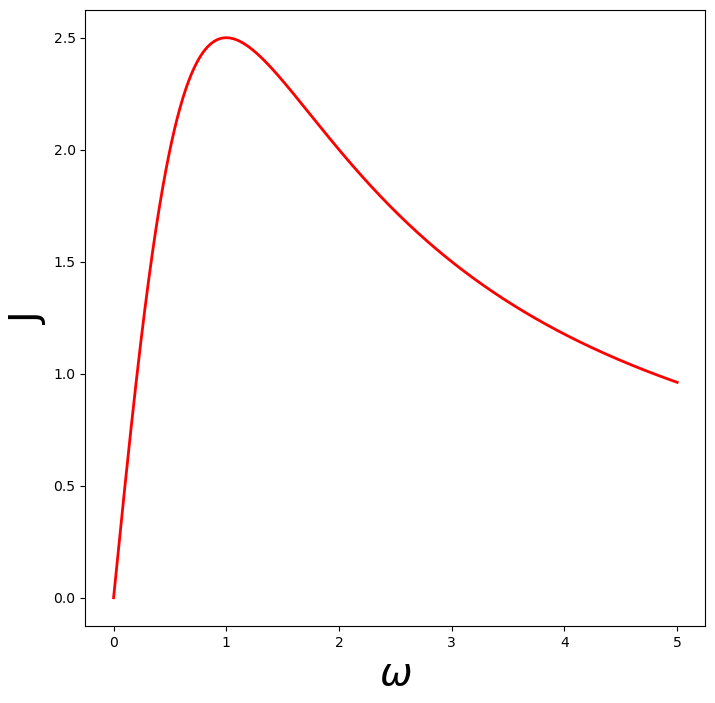

In [9]:
env = DrudeLorentzEnvironment(lam=lam, gamma=gamma, T=T, Nk=500)
w = np.linspace(0, 5, 1000)
J = env.spectral_density(w)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
axes.plot(w, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28);

## Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator

In [10]:
with timer("RHS construction time"):
    matsEnv = env.approximate(method="matsubara", Nk=Nk)
    HEOMMats = HEOMSolver(Hsys, (matsEnv, Q), NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.019459247589111328
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.38s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.38s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.39s / Remaining 00:00:00:00

 Total run time:   0.39s
ODE solver time: 0.3947288990020752


## Simulation 2: Matsubara decomposition (including terminator)

In [11]:
with timer("RHS construction time"):
    matsEnv, delta = env.approximate(
        method="matsubara", Nk=Nk, compute_delta=True
    )
    terminator = system_terminator(Q, delta)
    Ltot = liouvillian(Hsys) + terminator
    HEOMMatsT = HEOMSolver(Ltot, (matsEnv, Q), NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.01989293098449707


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 Total run time:   0.40s
ODE solver time: 0.4009380340576172


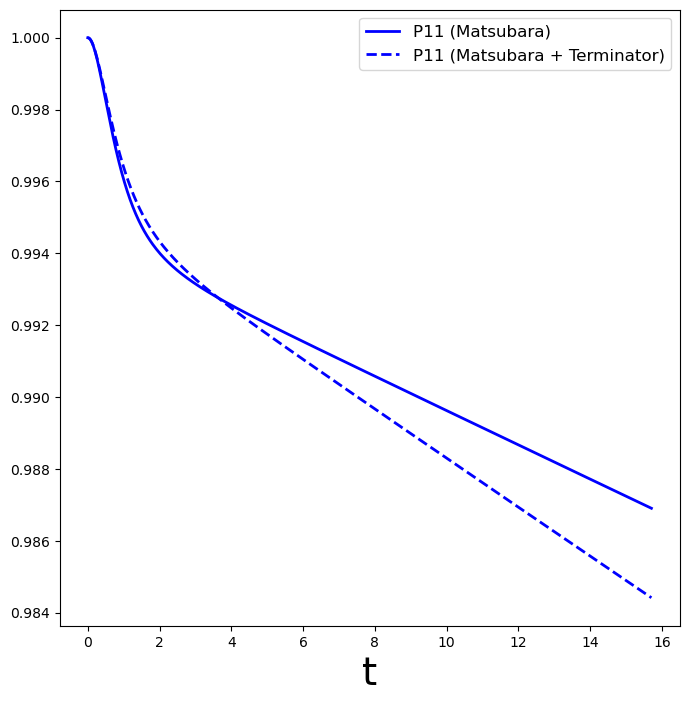

In [12]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

P11_mats = np.real(expect(resultMats.states, P11p))
axes.plot(
    tlist, np.real(P11_mats),
    'b', linewidth=2, label="P11 (Matsubara)",
)

P11_matsT = np.real(expect(resultMatsT.states, P11p))
axes.plot(
    tlist, np.real(P11_matsT),
    'b--', linewidth=2,
    label="P11 (Matsubara + Terminator)",
)

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12);

## Simulation 3: Pade decomposition

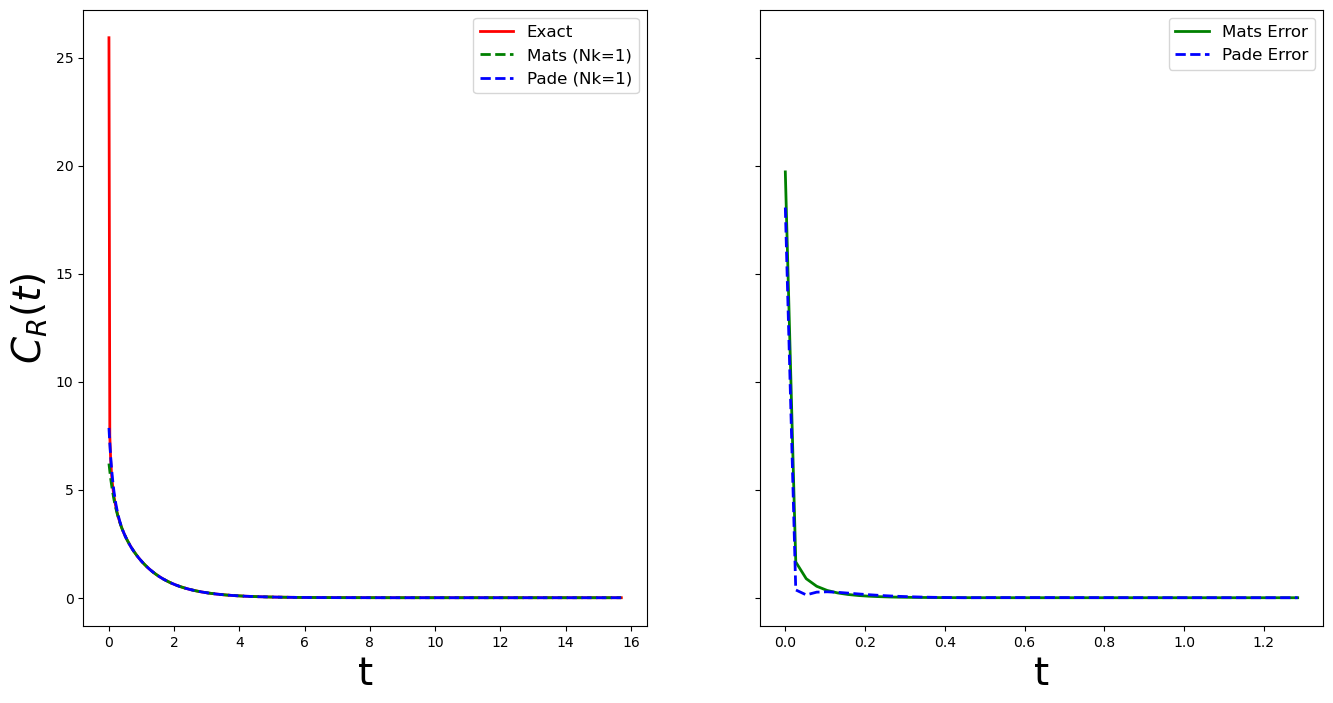

In [13]:
# First, compare Matsubara and Pade decompositions
padeEnv = env.approximate("pade", Nk=Nk)


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 8))

ax1.plot(
    tlist, np.real(env.correlation_function(tlist)),
    "r", linewidth=2, label="Exact",
)
ax1.plot(
    tlist, np.real(matsEnv.correlation_function(tlist)),
    "g--", linewidth=2, label=f"Mats (Nk={Nk})",
)
ax1.plot(
    tlist, np.real(padeEnv.correlation_function(tlist)),
    "b--", linewidth=2, label=f"Pade (Nk={Nk})",
)

ax1.set_xlabel(r't', fontsize=28)
ax1.set_ylabel(r"$C_R(t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)

tlist2 = tlist[0:50]
ax2.plot(
    tlist2, np.abs(matsEnv.correlation_function(tlist2)
                   - env.correlation_function(tlist2)),
    "g", linewidth=2, label="Mats Error",
)
ax2.plot(
    tlist2, np.abs(padeEnv.correlation_function(tlist2)
                   - env.correlation_function(tlist2)),
    "b--", linewidth=2, label="Pade Error",
)

ax2.set_xlabel(r't', fontsize=28)
ax2.legend(loc=0, fontsize=12);

In [14]:
with timer("RHS construction time"):
    HEOMPade = HEOMSolver(Hsys, (padeEnv, Q), NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.019361257553100586
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.41s / Remaining 00:00:00:00

 Total run time:   0.41s
ODE solver time: 0.413743257522583


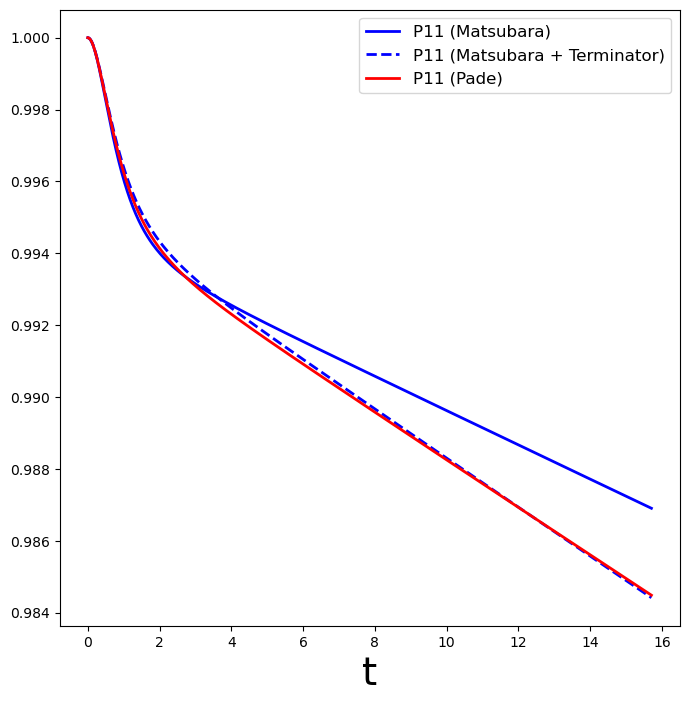

In [15]:
# Plot the results
fig, axes = plt.subplots(figsize=(8, 8))

axes.plot(
    tlist, np.real(P11_mats),
    'b', linewidth=2, label="P11 (Matsubara)",
)
axes.plot(
    tlist, np.real(P11_matsT),
    'b--', linewidth=2, label="P11 (Matsubara + Terminator)",
)

P11_pade = np.real(expect(resultPade.states, P11p))
axes.plot(
    tlist, np.real(P11_pade),
    'r', linewidth=2, label="P11 (Pade)",
)

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12);

## Simulation 4: Fitting approach

In `HEOM 1a: Spin-Bath model (introduction)` there is an example of a manually performed fit, here
we will only use the built-in tools. More details about them can be seen in 
`HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions`

In [16]:
tfit = np.linspace(0, 10, 10000)
lower = [0, -np.inf, -1e-6, -3]
guess = [np.real(env.correlation_function(0)) / 10, -10, 0, 0]
upper = [5, 0, 1e-6, 0]
# for better fits increase the first element in upper, or change approximate
# method that makes the simulation much slower (Larger C(t) as C(0) is fit
# better)

envfit, fitinfo = env.approximate(
    "cf", tlist=tfit, Nr_max=2, Ni_max=1, full_ansatz=True,
    sigma=0.1, maxfev=1e6, target_rmse=None,
    lower=lower, upper=upper, guess=guess,
)

In [17]:
print(fitinfo["summary"])

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 2 terms:                    |of the correlation function with 1 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |   vki    |  cki        | Parameters|   ckr    |   vkr    |   vki    |  cki         
 1         | 5.00e+00 |-1.91e+01 |-3.81e-07 |-2.97e+00    | 1         | 4.10e+00 |-1.00e+00 |-9.18e-07 |-2.50e+00     
 2         | 5.00e+00 |-1.07e+00 | 3.03e-07 |-1.06e-04    |                                                           
                                                          |A RMSE of  1.00e-02 was obtained for the the imaginary part
A RMSE of  6.46e-03 was obtained for the the real part of |of the correlation function.                               
the correlation funct

We can quickly compare the result of the fit with the Pade expansion

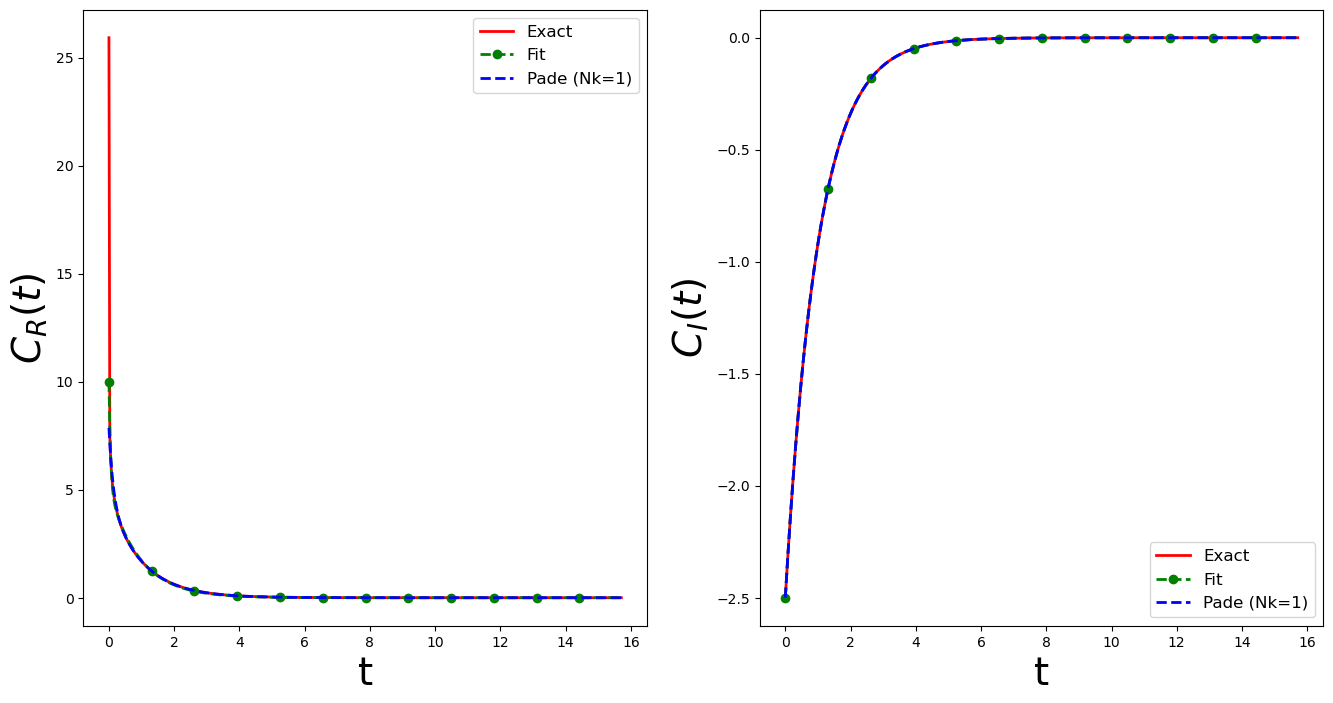

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.plot(
    tlist, np.real(env.correlation_function(tlist)),
    "r", linewidth=2, label="Exact",
)
ax1.plot(
    tlist, np.real(envfit.correlation_function(tlist)),
    "g--", linewidth=2, label="Fit", marker="o", markevery=50,
)
ax1.plot(
    tlist, np.real(padeEnv.correlation_function(tlist)),
    "b--", linewidth=2, label=f"Pade (Nk={Nk})",
)

ax1.set_xlabel(r"t", fontsize=28)
ax1.set_ylabel(r"$C_R(t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)

ax2.plot(
    tlist, np.imag(env.correlation_function(tlist)),
    "r", linewidth=2, label="Exact",
)
ax2.plot(
    tlist, np.imag(envfit.correlation_function(tlist)),
    "g--", linewidth=2, label="Fit", marker="o", markevery=50,
)
ax2.plot(
    tlist, np.imag(padeEnv.correlation_function(tlist)),
    "b--", linewidth=2, label=f"Pade (Nk={Nk})",
)

ax2.set_xlabel(r"t", fontsize=28)
ax2.set_ylabel(r"$C_I(t)$", fontsize=28)
ax2.legend(loc=0, fontsize=12)
plt.show()

In [19]:
with timer("RHS construction time"):
    # We reduce NC slightly here for speed of execution because we retain
    # 3 exponents in ckAR instead of 1. Please restore full NC for
    # convergence though:
    HEOMFit = HEOMSolver(Hsys, (envfit, Q), int(NC * 0.7), options=options)

with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.021216630935668945
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.63s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.63s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.63s / Remaining 00:00:00:00

 Total run time:   0.63s
ODE solver time: 0.6274466514587402


## Simulation 5: Bloch-Redfield

In [20]:
with timer("ODE solver time"):
    resultBR = brmesolve(
        Hsys, rho0, tlist,
        a_ops=[[sigmaz(), env]], sec_cutoff=0, options=options,
    )

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.25s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.26s / Remaining 00:00:00:00

 Total run time:   0.26s
ODE solver time: 0.2575249671936035


## Let's plot all our results

Finally, let's plot all of our different results to see how they shape up against each other.

In [21]:
# Calculate expectation values in the bases:
P11_mats = np.real(expect(resultMats.states, P11p))
P11_matsT = np.real(expect(resultMatsT.states, P11p))
P11_pade = np.real(expect(resultPade.states, P11p))
P11_fit = np.real(expect(resultFit.states, P11p))
P11_br = np.real(expect(resultBR.states, P11p))

In [22]:
rcParams = {
    "axes.titlesize": 25,
    "axes.labelsize": 30,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 28,
    "axes.grid": False,
    "savefig.bbox": "tight",
    "lines.markersize": 5,
    "font.family": "STIXgeneral",
    "mathtext.fontset": "stix",
    "font.serif": "STIX",
    "text.usetex": False,
}

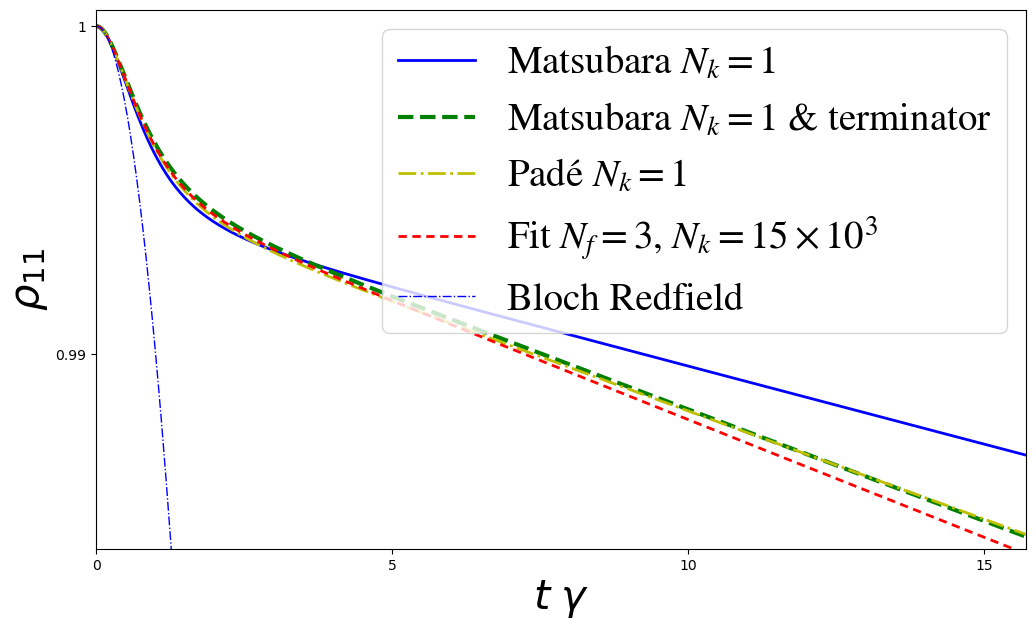

In [23]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

with plt.rc_context(rcParams):
    # Plot the results
    plt.yticks([0.99, 1.0], [0.99, 1])
    axes.plot(
        tlist, np.real(P11_mats),
        'b', linewidth=2, label=f"Matsubara $N_k={Nk}$",
    )
    axes.plot(
        tlist, np.real(P11_matsT),
        'g--', linewidth=3,
        label=f"Matsubara $N_k={Nk}$ & terminator",
    )
    axes.plot(
        tlist, np.real(P11_pade),
        'y-.', linewidth=2, label=f"Padé $N_k={Nk}$",
    )
    axes.plot(
        tlist, np.real(P11_fit),
        'r', dashes=[3, 2], linewidth=2,
        label=r"Fit $N_f = 3$, $N_k=15 \times 10^3$",
    )
    axes.plot(
        tlist, np.real(P11_br),
        'b-.', linewidth=1, label="Bloch Redfield",
    )

    axes.locator_params(axis='y', nbins=6)
    axes.locator_params(axis='x', nbins=6)
    axes.set_ylabel(r'$\rho_{11}$', fontsize=30)
    axes.set_xlabel(r'$t\;\gamma$', fontsize=30)
    axes.set_xlim(tlist[0], tlist[-1])
    axes.set_ylim(0.98405, 1.0005)
    axes.legend(loc=0)

## About

In [24]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)


Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-qtrl: 0.2.0.dev0+acb71a0


qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [25]:
assert np.allclose(P11_matsT, P11_pade, rtol=1e-3)
assert np.allclose(P11_matsT, P11_fit, rtol=1e-3)